# What is lambeq?

Lambeq is an open-source, modular, extensible high-level Python library for experimental Quantum Natural Language Processing (QNLP), created by Cambridge Quantum’s QNLP team. At a high level, the library allows the conversion of any sentence to a quantum circuit, based on a given **compositional model** and certain parameterisation and choices of **ansätze**, and facilitates training for both quantum and classical NLP experiments.

## What is a compositional model? 

A model that produces semantic representations of sentences by composing together the semantic representations of the words within them. The model that we will be using is **DisCoCat** (Distributional Compositional Categorical). Other examples of compositional models include **Bag-of-Words** and **Word Sequence Model**.

## What is ansätze?

Ansatz, German for 'approach', means the model that we will adapt to convert the sentence into a quantum circuit. The ansatz which lambeq uses to make quantum circuits is called the **IQP Ansatz** (Instantaneous Quantum Polynomial). The ansatz for the classical case is the **MPS Ansatz** (Matrix Product States), to convert the sentence into a tensor network.

## What is the procedure from Sentence to Circuit?

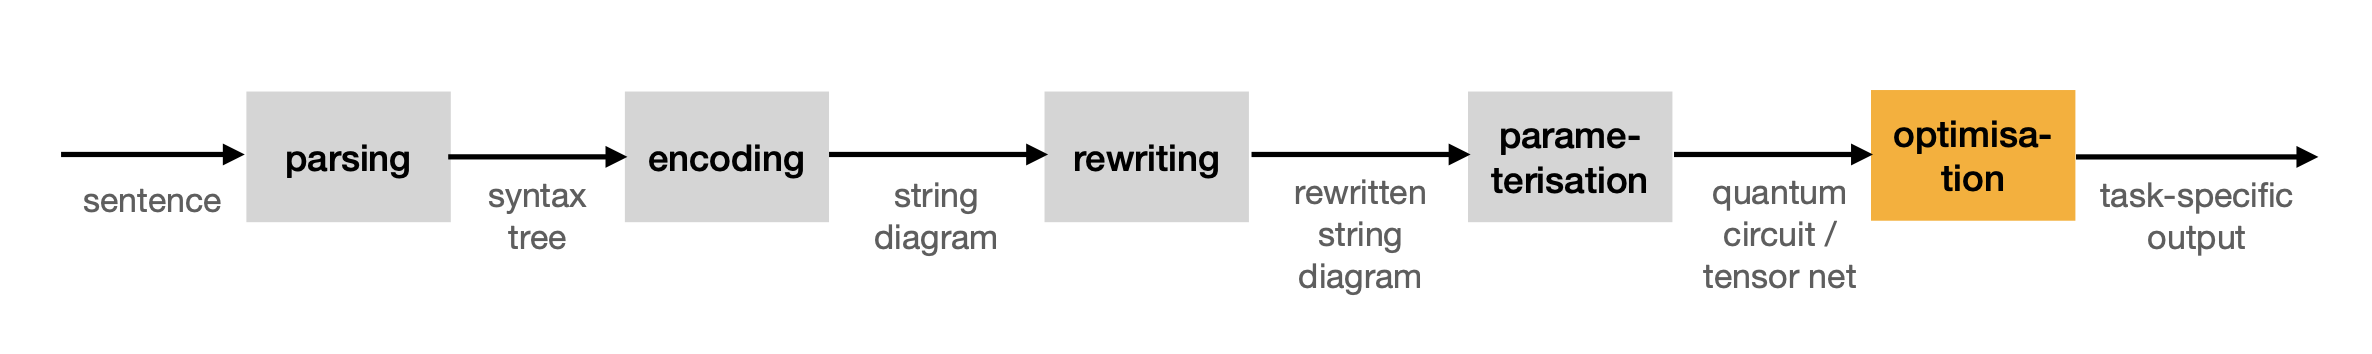



After we enter the sentence as a string, it is first parsed by the in-house BobCatParser to make a syntax tree, describing the syntactical relationships between the words. 
BobCatParser is based on the CCG (Combinatory Categorial Grammar) grammar formalism, and provides an intermediate between the more rigid pregroup grammar, and context-free grammar.  
This syntax tree is then represented visually as a string diagram. 
With this string diagram in hand, then we apply the rewrite rules, where we simplify the diagram, so that the conversion to a quantum circuit is more efficient and more computable. 
This is done through ansatze, specifically the IQP (Instantaneous Quantum Polynomial) ansatz, where we interleave Hadamard gates with controlled-Z rotations. 

### Terminology:

##### Parser: 

A statistical tool that converts a sentence into a hierarchical representation that reflects the syntactic relationships between the words (a syntax tree) based on a specific grammar formalism.

##### CCG (Combinatory Categorial Grammar):

##### Pregroup Grammar: 

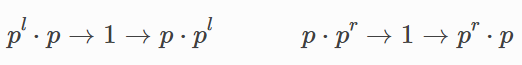

##### Category:

In category theory, a category is a mathematical structure that consists of a collection of objects and a collection of morphisms between objects, forming a labelled directed graph. A category has two basic properties: the ability to compose the arrows associatively and the existence of an identity arrow for each object. lambeq structures are expressed in terms of a monoidal category.

##### Monoidal Categories: 
A category equipped with the monoidal product <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo>&#x2297;</mo>
</math> 
and monoidal unit 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>I</mi>
</math>,
providing an abstraction suitable for quantum computation. Categorical quantum mechanics (CQM) and DisCoCat are both based on the mathematical framework of monoidal categories.


In [2]:
from lambeq import BobcatParser, Rewriter, spiders_reader, cups_reader, stairs_reader, TreeReader
from discopy import grammar, Ob, Ty

C:\Users\nitro\anaconda3\lib\site-packages\lambeq\text2diagram\ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Types of Readers



## Syntax based Model: DisCoCat (BobCat Reader)

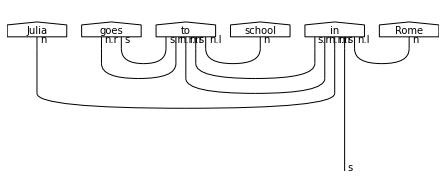

In [3]:
sentence = 'Julia goes to school in Rome'

parser = BobcatParser()
diagram = parser.sentence2diagram(sentence)

grammar.draw(diagram)

### Bag-of-Words: Spiders Reader

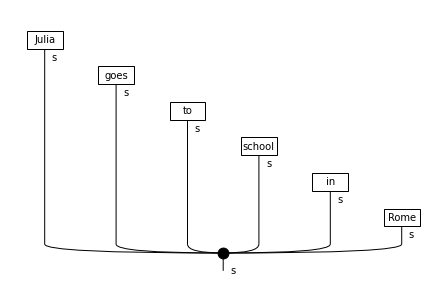

In [4]:
spiders_diagram = spiders_reader.sentence2diagram(sentence)

spiders_diagram.draw()

### Word-sequence models: Cups and stairs readers

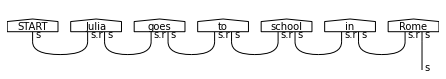

In [5]:
cups_diagram = cups_reader.sentence2diagram(sentence)

grammar.draw(cups_diagram)

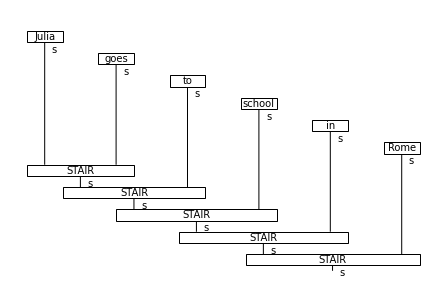

In [6]:
stairs_diagram = stairs_reader.sentence2diagram(sentence)

stairs_diagram.draw()

### Tree Readers

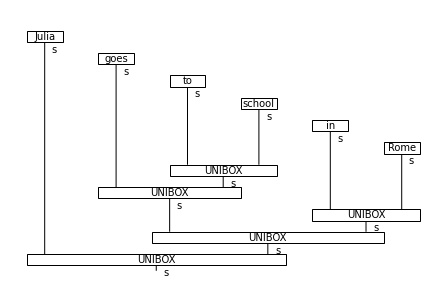

In [7]:
from lambeq import TreeReaderMode

reader = TreeReader()

tree_diagram = reader.sentence2diagram(sentence)

tree_diagram.draw()

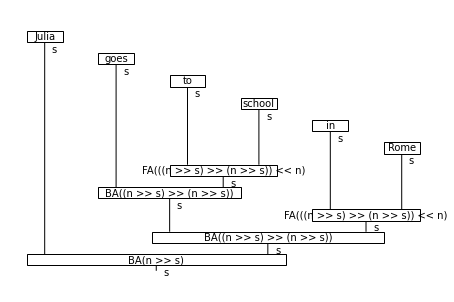

In [8]:
reader = TreeReader(mode=TreeReaderMode.RULE_TYPE)

tree_diagram = reader.sentence2diagram(sentence)

tree_diagram.draw()

### Diagram Rewriting

Sentences in their original form can become quite complex for a quantum circuit conversion, and will not be hardware and resource efficient. So, to preserve the core meaning of the sentence, and reduce the demands on the quantum hardware, they have devised certain rewrite rules. 
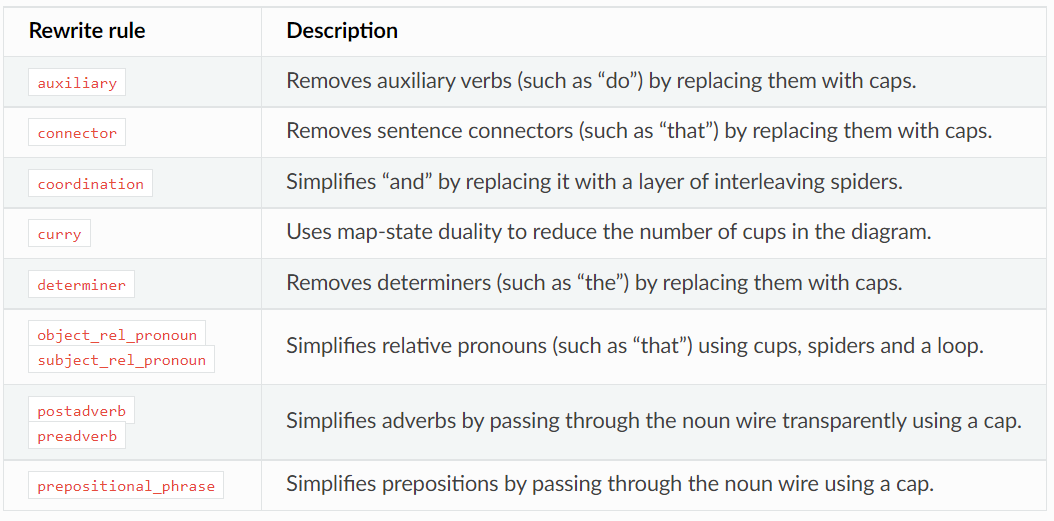

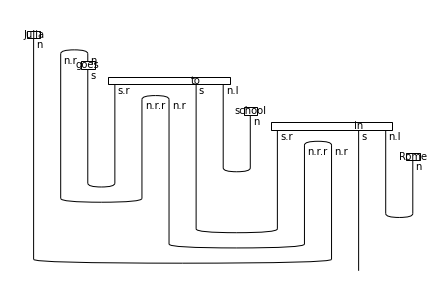

In [4]:
rewriter = Rewriter(['determiner','auxiliary', 'prepositional_phrase', 'curry'])
rewritten_diagram = rewriter(diagram)

rewritten_diagram.draw()

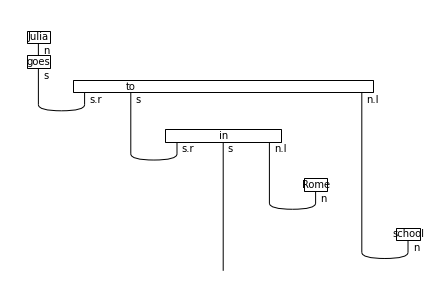

In [8]:
normalised_diagram = rewritten_diagram.normal_form()
normalised_diagram.draw()

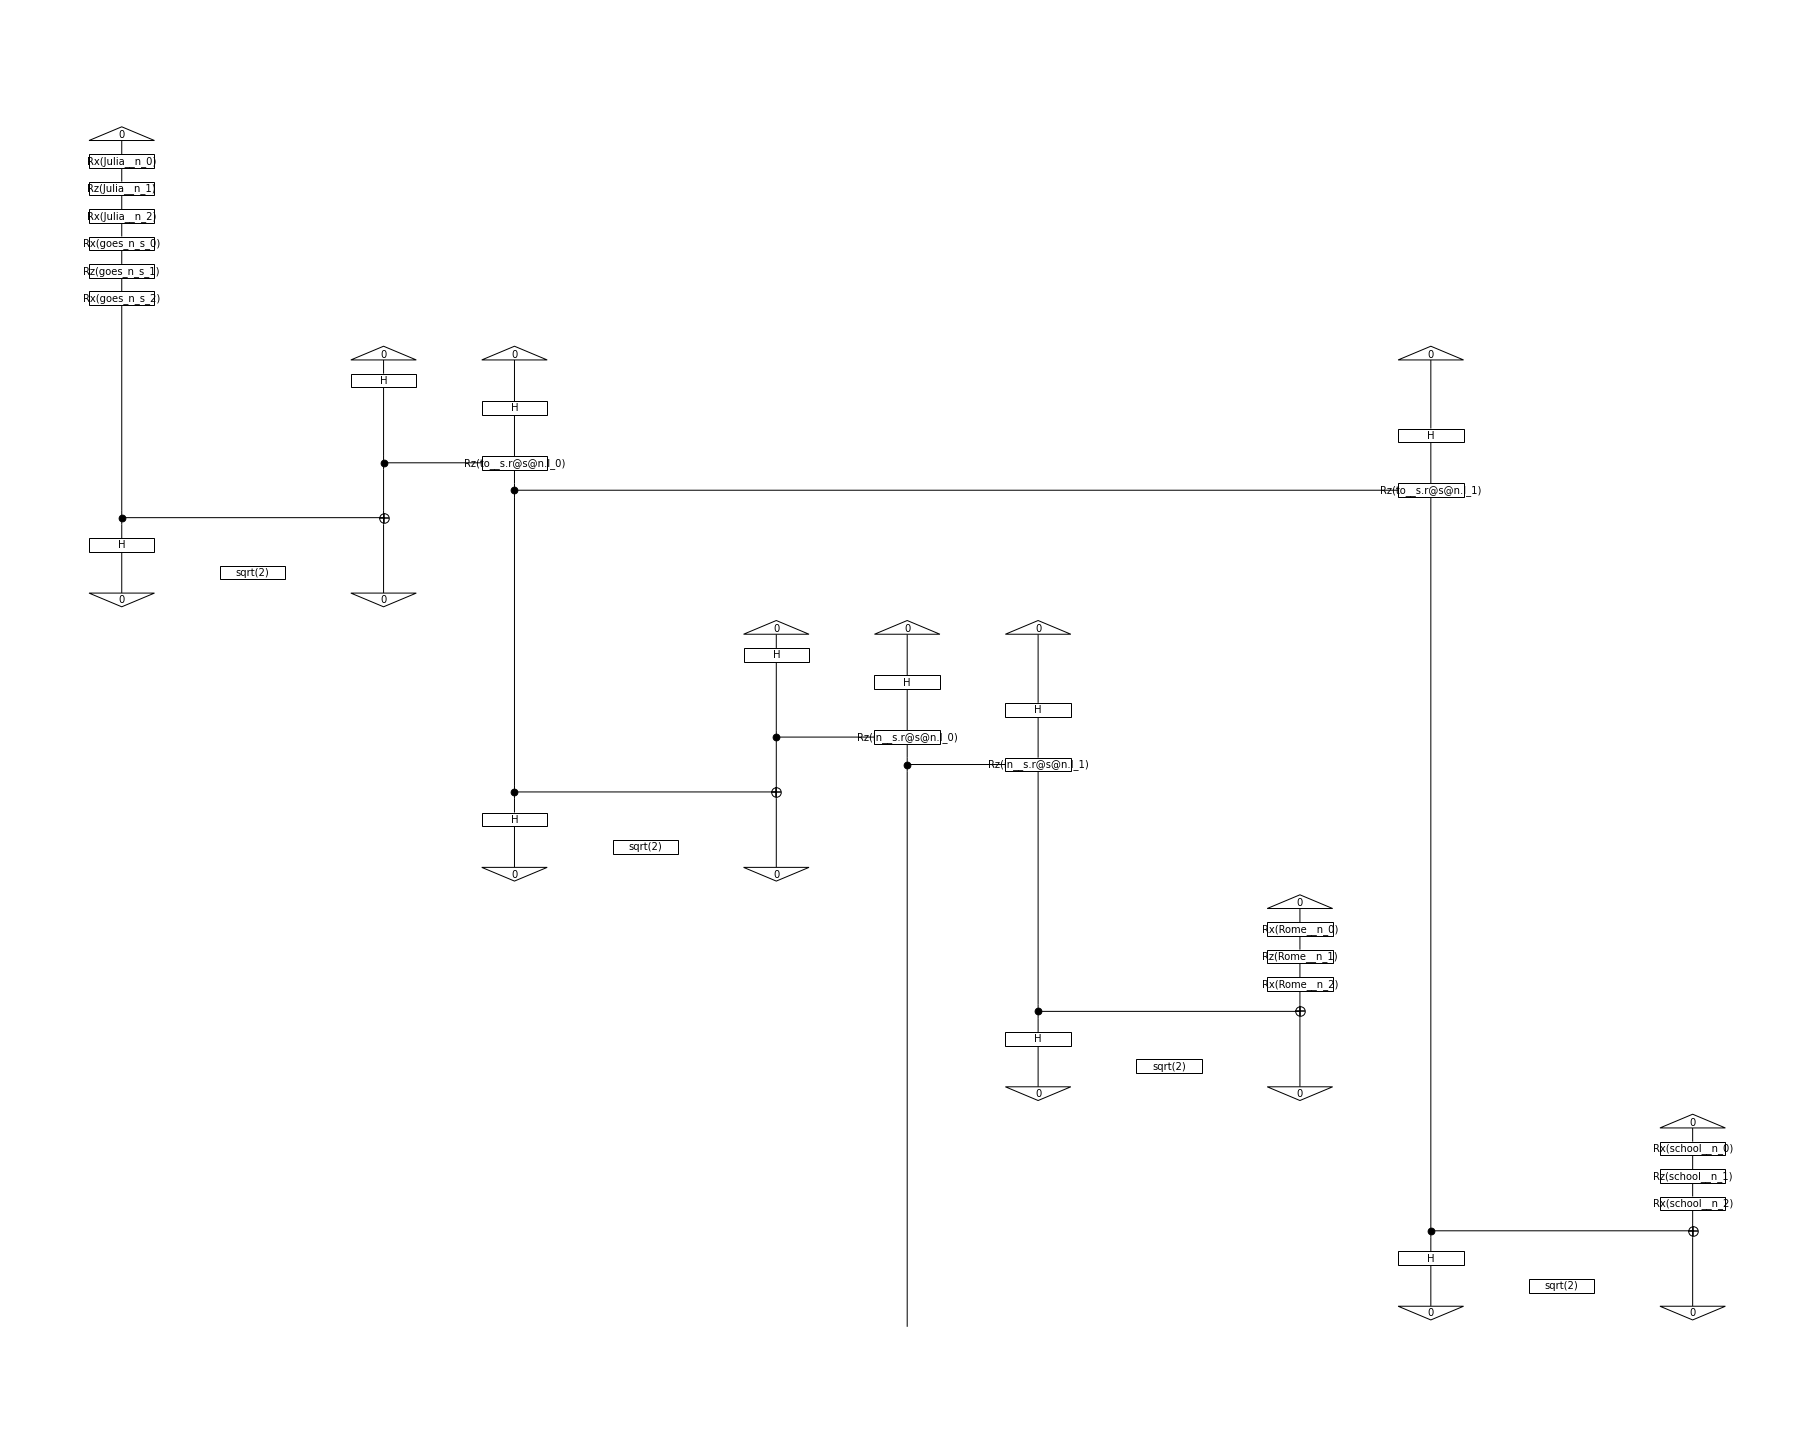

In [10]:
from lambeq import AtomicType, IQPAnsatz

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE

ansatz = IQPAnsatz({N:1, P:1, S:1}, n_layers=1)
discopy_circuit = ansatz(normalised_diagram)
discopy_circuit.draw(figsize=(25,20))

## Create a hardware agnostic tket circuit

In [12]:
from pytket.circuit.display import render_circuit_jupyter

In [13]:
tket_circuit = discopy_circuit.to_tk()

render_circuit_jupyter(tket_circuit)

## Convert tket circuit to qiskit circuit

In [1]:
from pytket.extensions.qiskit import tk_to_qiskit

In [12]:
qiskit_circuit = tk_to_qiskit(tket_circuit)

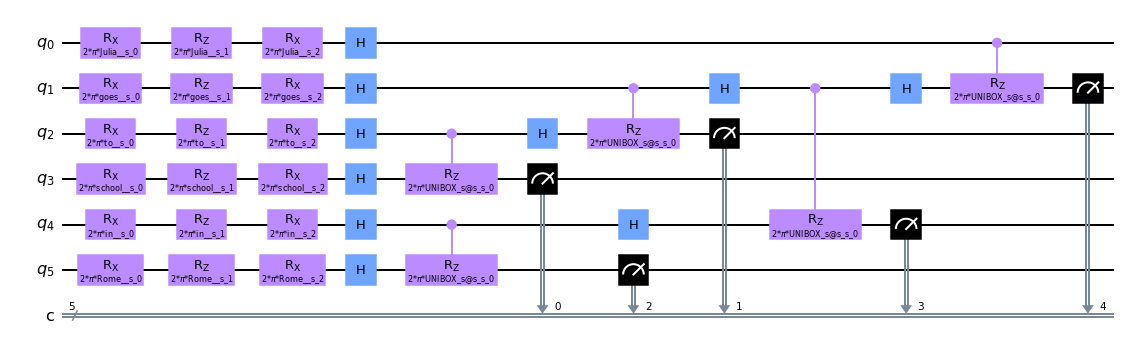

In [13]:
qiskit_circuit.draw('mpl')

## Assign arbitrary values to the parameters of the variational quantum circuit

In [18]:
from sympy import default_sort_key


# Make sure you sort your symbols as they are returned as a set.
parameters = sorted(tket_circuit.free_symbols(), key=default_sort_key)

param_dict = {p: i * 0.001 for i, p in enumerate(parameters)}
param_dict

{Julia__n_0: 0.0,
 Julia__n_1: 0.001,
 Julia__n_2: 0.002,
 Rome__n_0: 0.003,
 Rome__n_1: 0.004,
 Rome__n_2: 0.005,
 goes_n_s_0: 0.006,
 goes_n_s_1: 0.007,
 goes_n_s_2: 0.008,
 in__s.r@s@n.l_0: 0.009000000000000001,
 in__s.r@s@n.l_1: 0.01,
 school__n_0: 0.011,
 school__n_1: 0.012,
 school__n_2: 0.013000000000000001,
 to__s.r@s@n.l_0: 0.014,
 to__s.r@s@n.l_1: 0.015}

In [19]:
tket_circuit.symbol_substitution(param_dict)

render_circuit_jupyter(tket_circuit)

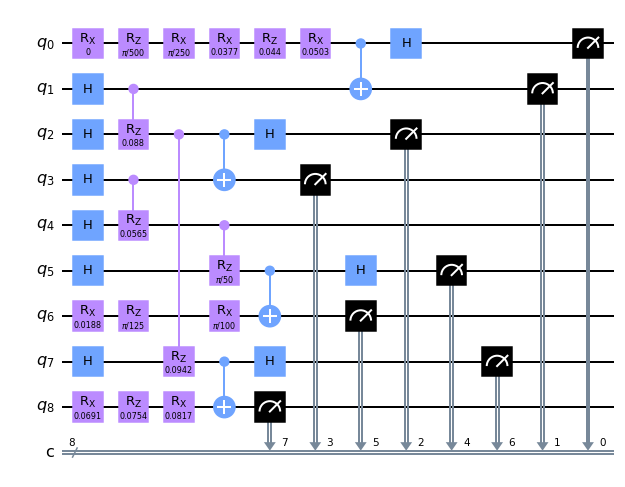

In [20]:
qiskit_circuit = tk_to_qiskit(tket_circuit)
qiskit_circuit.draw('mpl')

In [15]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
%matplotlib inline

In [29]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qiskit_circuit, backend)

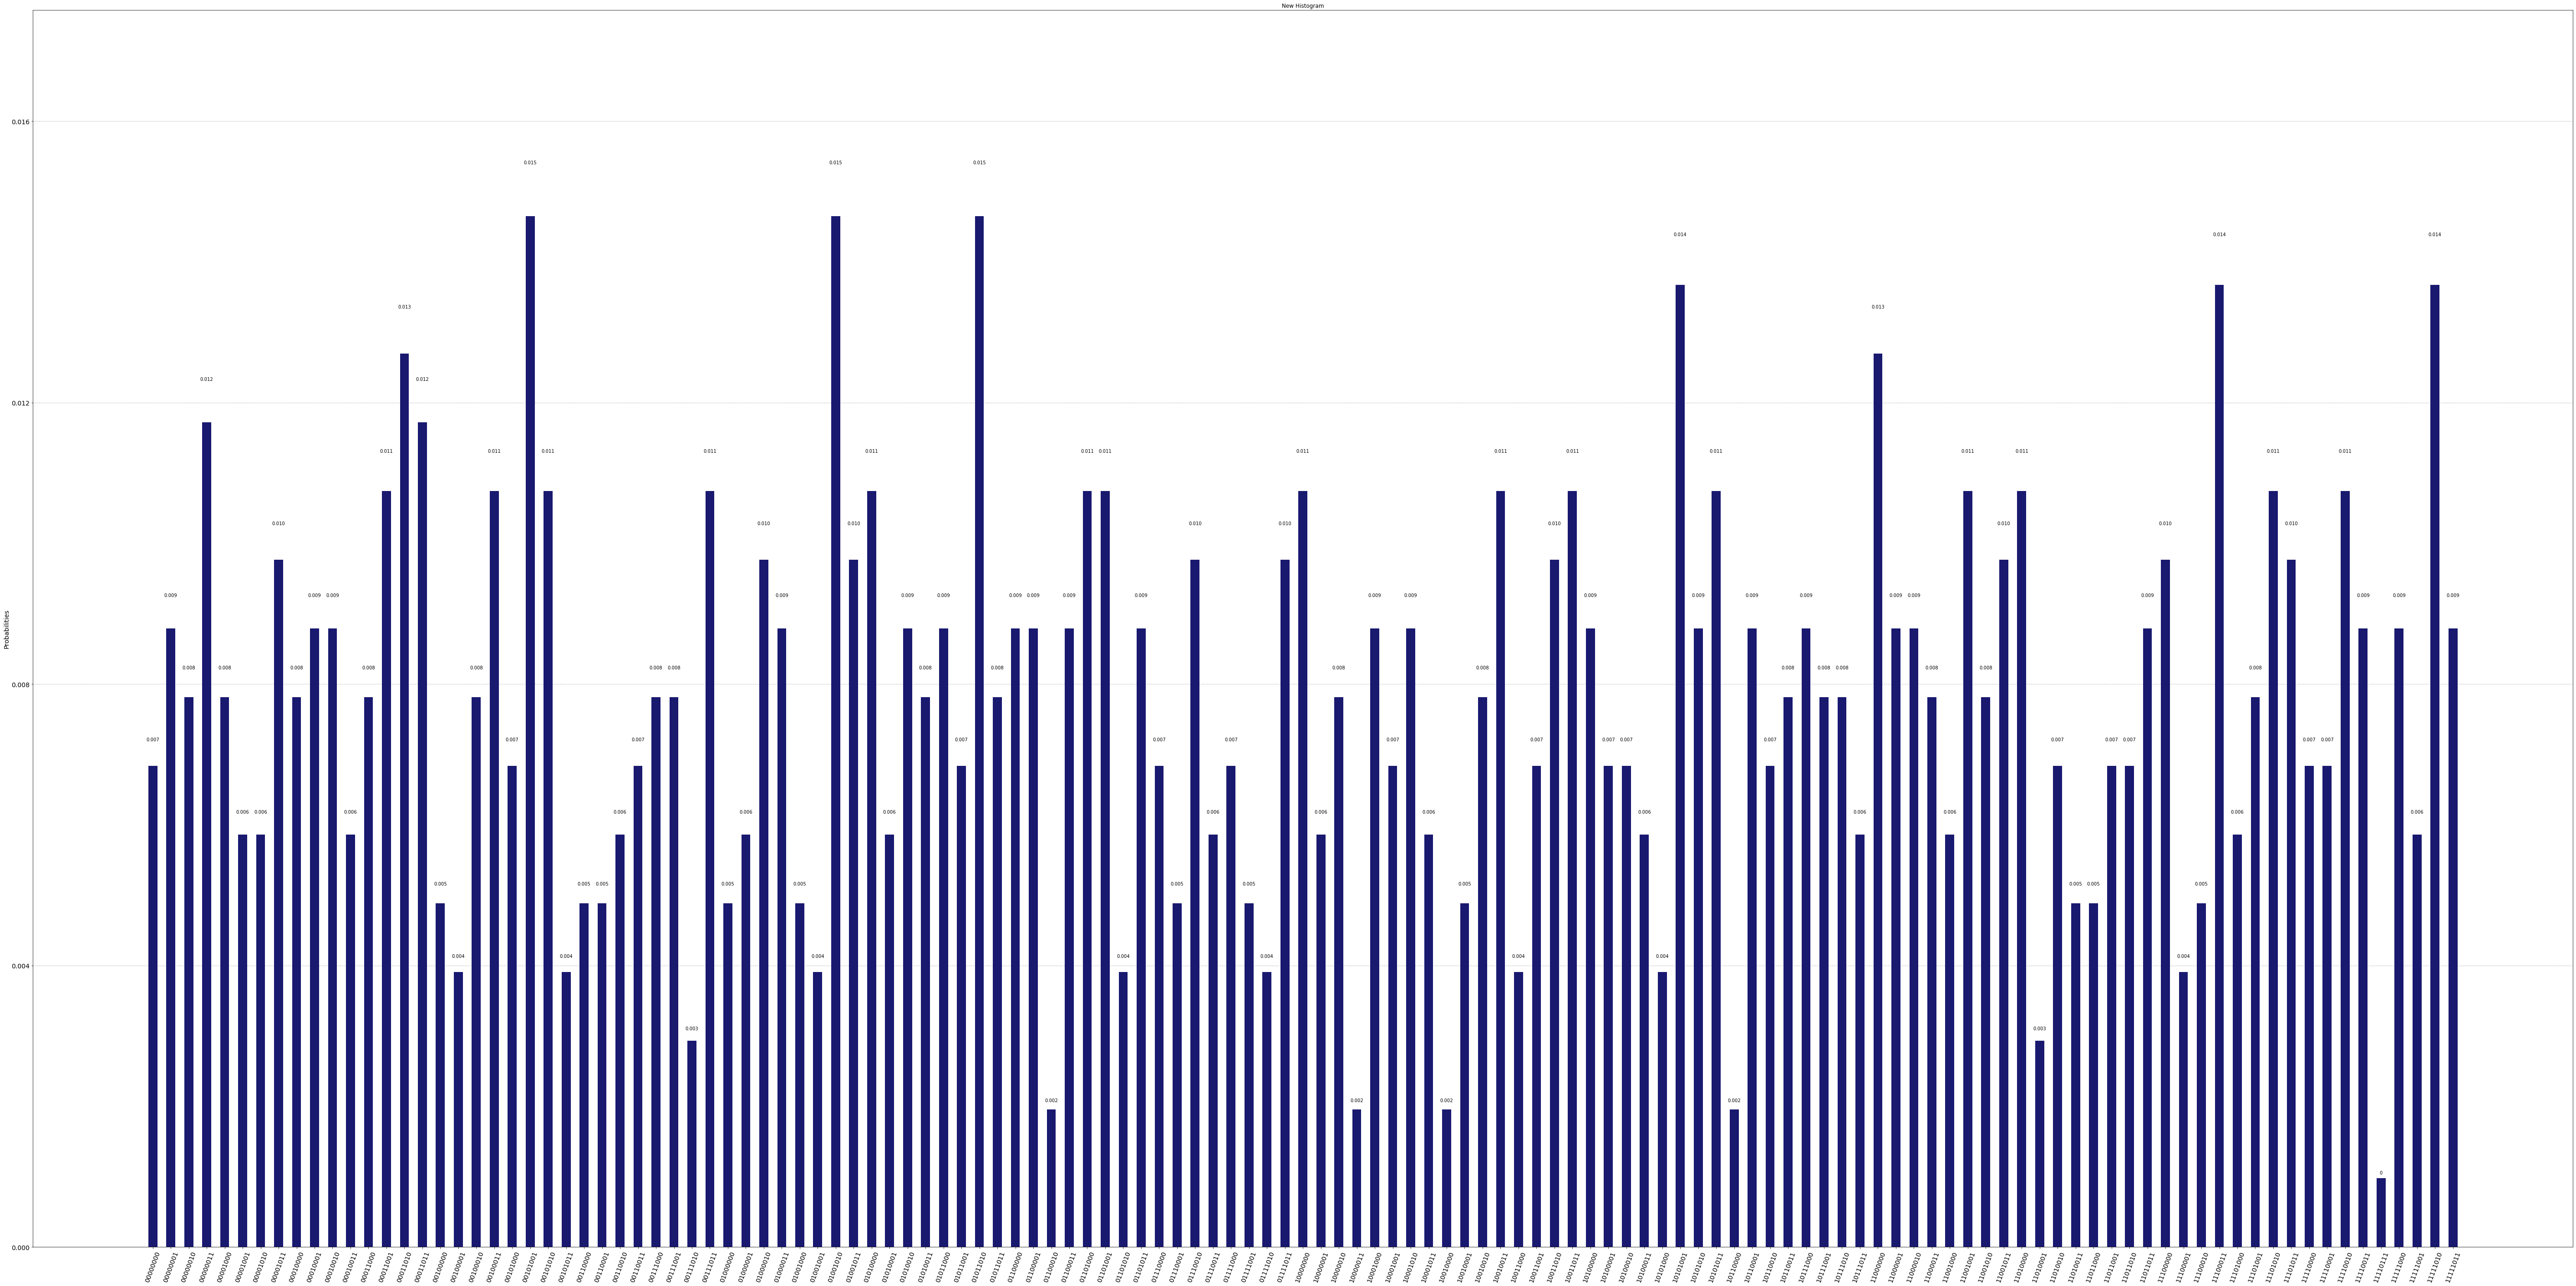

In [28]:
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram", figsize=(100, 50))

In [2]:
import numpy as np